In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

In [2]:
from NVcenter import *

In [ ]:
# Create, save and load random spin baths

# spin_baths = save_spin_baths('C13_bath_configs', DATA_DIR, 'C13', 0.02e-2, 2e-9, 4.2e-9, 10, 10)
bath_configs = list(load_spin_baths('C13_bath_configs', DATA_DIR).values())

In [30]:
# Compare my Hamiltonian to the Suter Hamiltonian 

register_config = [('NV', (0, 0, 0), 0, {}), ('C13', (4.722331100730915e-10, 0.0, 1.030637866442101e-10), 0, {})]
bath_config = SpinBath('C13', 0.02e-2, 2e-9, 4.2e-9).config
approx_level = 'no_bath'

hamiltonian = Hamiltonian(register_config, bath_config, approx_level)
print( hamiltonian.matrices[0] )

print( H_Suter() )

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-7.92420875e+04  0.00000000e+00  3.88908730e+04  1.78196033e+05]
 [ 0.00000000e+00  7.92420875e+04  5.37401154e+04 -3.88908730e+04]
 [ 3.88908730e+04  5.37401154e+04  2.45326996e+09 -5.50000000e+04]
 [ 1.78196033e+05 -3.88908730e+04 -5.50000000e+04  2.45327645e+09]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79000.      0.      0.      0.]
 [     0.  79000.      0.      0.]
 [     0.      0.  -3000. -55000.]
 [     0.      0. -55000.   3000.]]


In [4]:
# Analytical times 

C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10)
T1, T2 = calc_hadamard_pulse_seq(C13_pos)

register_config = [('NV', (0, 0, 0), 0, {}), ('C13', (4.722331100730915e-10, 0.0, 1.030637866442101e-10), 0, {})]
bath_config = SpinBath('C13', 0.02e-2, 2e-9, 4.2e-9).config
approx_level = 'gCCE0'

pulse_seq = [0] # Suter Hadamard 
target = q.tensor(q.qeye(2), q.qeye(2))

pulse = Pulse(pulse_seq, register_config, bath_config, approx_level, target, old_state=None, mode='state_preparation' )

pi_pulse = pulse.calc_U_rot(np.pi, 0)
H = 2*np.pi * pulse.matrices[0].full()
eigv, eigs = np.linalg.eigh( H )
free_evo1 = pulse.calc_U_time(eigv, eigs, T1)
free_evo2 = pulse.calc_U_time(eigv, eigs, T2)

old_state = pulse.init_states[0]
pulse_matrix = free_evo2 * pi_pulse * free_evo1 * pi_pulse
new_state = pulse_matrix * old_state * pulse_matrix.dag()
print( new_state[1, 1].real )

0.4999587814818642


## Ramsey Protocol

In [ ]:
nv1_config = ('NV', (0,0,0), 1, {})
nv2_config = ('NV', (20e-9,0,0), 1, {})

two_spin_system = TwoSpinSystem(nv1_config, nv2_config, 100e-6)

fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))
ax[0] = two_spin_system.plot_observables(ax[0], ['S1z', 'S2z'])
ax[1] = two_spin_system.plot_pops(ax[1])
plt.show()

## Two Spin System

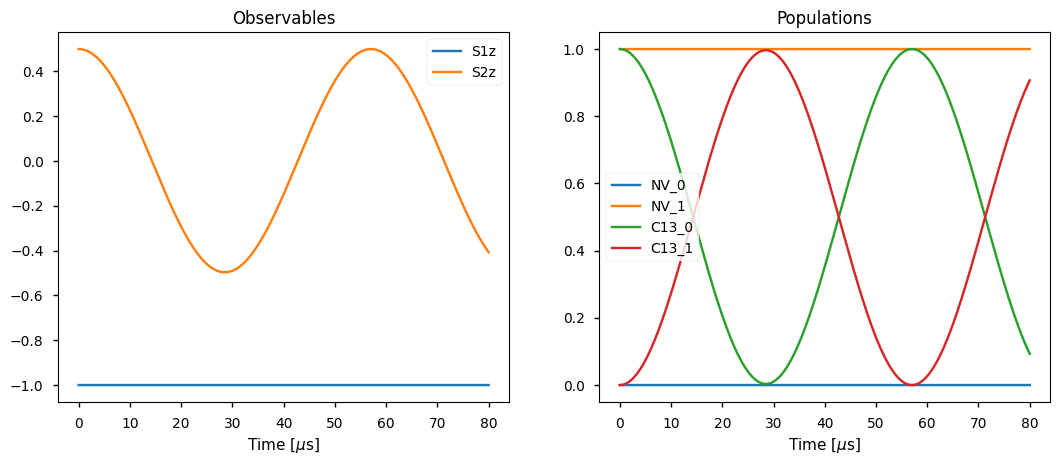

In [11]:
time = 80e-6
config_spin1 = ('NV', (0,0,0), 1, {})
config_spin2 = ('C13', (4.722331100730915e-10, 0.0, 1.030637866442101e-10), 0, {})
two_spin_system = TwoSpinSystem(config_spin1, config_spin2, time)

fig, ax = plt.subplots(1, 2, figsize = (6.4*2, 4.8))
ax[0] = two_spin_system.plot_observables(ax[0], ['S1z', 'S2z'])
ax[1] = two_spin_system.plot_pops(ax[1])
plt.show()

## Spin Bath

In [26]:
# Fig. 3 in Dominik's paper (binomial distribution)

rmin, rmax = 0, 1.8e-9
volume = 4/3 * np.pi * (rmax**3 - rmin**3)

a_C = DEFAULTS['a_C'] # lattice constant for carbon
V_unit = a_C**3 # volume of the unit cell
N_unit = DEFAULTS['N_unit'] # number of carbon atoms per unit cell
n = N_unit/V_unit # density of carbon atoms
N =  int(volume * n) # number of carbon atoms

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

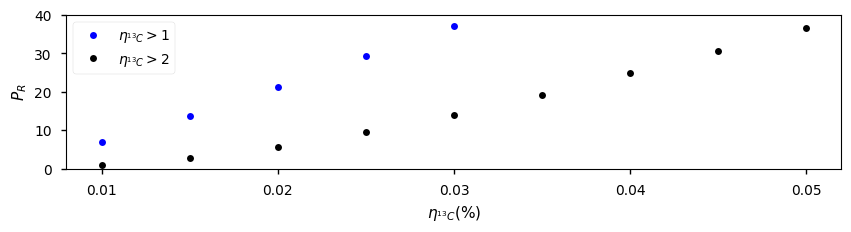

In [28]:
fig, ax = plt.subplots(figsize=(10,2))

ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')

# plot settings
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend()
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])

plt.show()

## Optimization

In [ ]:
# Optimize pulse sequence 
from scipy.optimize import basinhopping, Bounds

def print_progress(x, f, accepted):
    print(f"Current parameters: {x}, Infidelity: {f}, Accepted: {accepted}")

register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )
init_pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]

spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax)
system_configs = spin_config.system_configs['no_bath']

def calc_infidelity(pulse_seq):
    system = System(system_configs, [])
    pulses = Pulses(system, pulse_seq, target_state)
    return 1 - pulses.final_fidelity

basinhopping(
    calc_infidelity, init_pulse_seq, 
    minimizer_kwargs={"method": "L-BFGS-B", "bounds": Bounds([0]*10, [10e-6]*4+[np.pi]*3+[2*np.pi]*3) },
    callback=print_progress, niter=10,
)